# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Fri Apr 29 12:16:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   40C    P0   122W / 300W |   4395MiB / 32505MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
#from rdkit import Chem
#from rdkit.Chem import AllChem

In [4]:
dataset = 'CHEMBL205'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978')]

In [7]:
DATA = path/'mol_images'

In [8]:
IMAGES = DATA/dataset

# Create train validation split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.is_valid.value_counts()

False    8611
True     2153
Name: is_valid, dtype: int64

In [11]:
len(df[df.is_valid == True]) / len(df[df.is_valid == False])

0.2500290326326791

# Create dataloader

In [12]:
from fastai.vision.all import *

In [13]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL1589687,S1c2n(ncn2)C(O)=C1C([NH+]1CCc2c(C1)cccc2)c1ccc(F)cc1,0,False,CHEMBL1589687.png
1,CHEMBL3092937,S(=O)(=O)(N)c1cc(ccc1)-c1nnn(c1)C1OC(COC(=O)C)C(OC(=O)C)C(OC(=O)C)C1OC(=O)C,1,False,CHEMBL3092937.png
2,CHEMBL325684,O=C1N(Cc2ccc(cc2)-c2ccccc2C(=O)[O-])C(=NC12CC2)CCCC,0,False,CHEMBL325684.png
3,CHEMBL488713,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1N=CCC1C(=O)Nc1ccccc1OCC(=O)[O-],0,False,CHEMBL488713.png
4,CHEMBL2069846,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1CCN(CC1)C(=O)c1ccc(N2CC[NH+](CC2)C)cc1,0,False,CHEMBL2069846.png


In [14]:
images = df['CID'] + ".png"
images.head()

0    CHEMBL1589687.png
1    CHEMBL3092937.png
2     CHEMBL325684.png
3     CHEMBL488713.png
4    CHEMBL2069846.png
Name: CID, dtype: object

In [15]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [16]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None,
    )

Oversmaple instead of using class weights to test custom loss function

In [17]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    #x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     #random_state=random_state)
    
    #df.loc[x_train, 'is_valid']=False
    #df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df


In [18]:
def get_df(dataset, random_state=42, test_size=0.25, oversample=True, test=False):
    if test:
        df = pd.read_csv(path/dataset/f'{dataset}_test1.csv')
    else:
        df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')
        df = val_cols_and_oversample(df, test_size=test_size, random_state=random_state, oversample=oversample)
    df['Image'] = df['CID'] + '.png'
    return df

In [19]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.25):
    df = pd.read_csv(path/dataset/f'{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [20]:
df = get_df(dataset, oversample=True)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL3092937,S(=O)(=O)(N)c1cc(ccc1)-c1nnn(c1)C1OC(COC(=O)C)C(OC(=O)C)C(OC(=O)C)C1OC(=O)C,1,False,CHEMBL3092937.png
1,CHEMBL215936,S(=O)(=O)(N)c1ccc(cc1)CCNC(=O)CCSSCCC(=O)NCCc1ccc(S(=O)(=O)N)cc1,1,False,CHEMBL215936.png
2,CHEMBL570257,S(=O)(=O)(N)c1cc(N=Nc2ccc(NCS(=O)(=O)[O-])cc2)ccc1,1,False,CHEMBL570257.png
3,CHEMBL1672445,S(=O)(=O)(N)c1ccc(NC2OC(C)C(O)C(O)C2O)cc1,1,False,CHEMBL1672445.png
4,CHEMBL467098,s1c(nnc1S(=O)(=O)N)NC(=O)c1nn(c(-c2ccccc2)c1C(OCC)=O)-c1cc(N)ccc1,1,False,CHEMBL467098.png


In [24]:
df_test = get_df(dataset, oversample=False, test=True)

In [25]:
IMAGES = DATA/f'{dataset}'
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205')

In [27]:
def get_dls(dataset, bs=64, clustering=False, random_state=42, oversample=False, test=False):
    IMAGES = DATA/f'{dataset}'
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset, oversample=oversample, test=test)
    if test:
        db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=IndexSplitter([]),
        item_tfms=None, 
        batch_tfms=None,
        )
        dls = db.dataloaders(df, bs=16, shuffle_train=False, random_state=42, num_workers=0)
    else:
        db = DataBlock(
            blocks = (ImageBlock(), CategoryBlock()), 
            get_x=ColReader('Image', pref=IMAGES),
            get_y=ColReader('Activity'), 
            splitter=ColSplitter('is_valid'),
            item_tfms=None, 
            batch_tfms=None,
            )
        dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42, num_workers=0)
    return dls, df

In [28]:
dls, df = get_dls(dataset, bs=32, clustering=False, oversample=True)

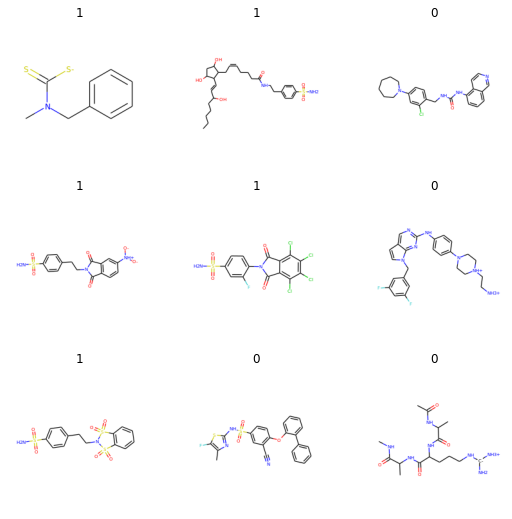

In [29]:
dls.show_batch()

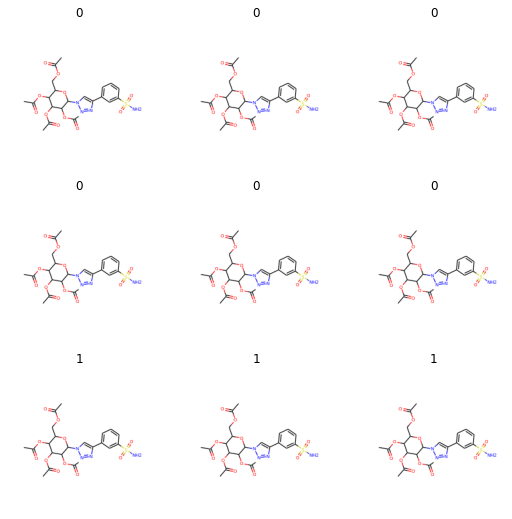

In [30]:
dls.show_batch(unique=True)

In [31]:
test_dls, test_df = get_dls(dataset, clustering=False, test=True)

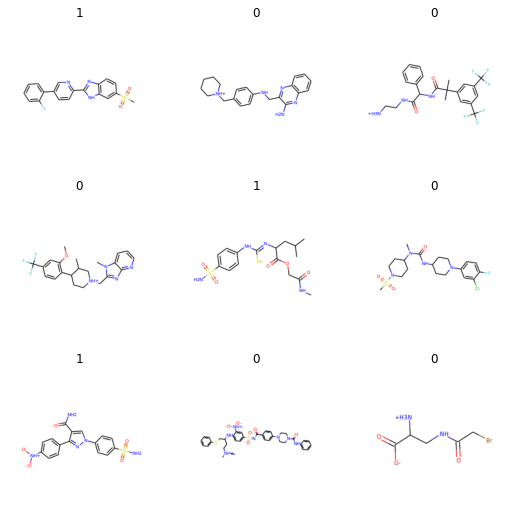

In [32]:
test_dls.show_batch()

# Train a cnn model in pytorch

In [33]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

<AxesSubplot:>

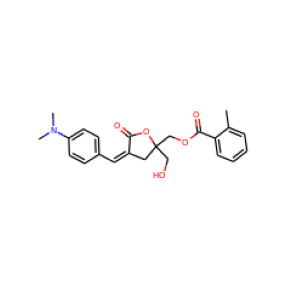

In [34]:
train_x, y = dls.one_batch()
show_image(train_x[0])

In [35]:
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import copy

In [36]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            p = 0.0
            all_preds = torch.Tensor().to(device)
            all_labels = torch.Tensor().to(device)
            
            if phase == 'train':
                dataloaders = dls.train
            else:
                dataloaders = dls.valid
            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    all_preds = torch.cat([all_preds, preds])
                    all_labels = torch.cat([all_labels, labels])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders.dataset) 
            result[f'{phase}_loss'] = epoch_loss
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)
            result[f'{phase}_acc'] = epoch_acc
            if phase == 'val':
                precision = precision_score(all_labels.cpu(), all_preds.cpu())
                recall = recall_score(all_labels.cpu(), all_preds.cpu())
                f_score = f1_score(all_labels.cpu(), all_preds.cpu())
                #auc_score = auc(all_labels.cpu(), all_preds.cpu())
                roc_auc = roc_auc_score(all_labels.cpu(), all_preds.cpu())
                result[f'{phase}_precision'] = precision
                result[f'{phase}_recall'] = recall
                result[f'{phase}_f1_score'] = f_score
                #result[f'{phase}_auc'] = auc_score
                result[f'{phase}_roc_auc'] = roc_auc
                print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 score: {:.4f} ROC AUC: {:.4f}'
                      .format(phase, epoch_loss, epoch_acc, precision, recall, f_score, roc_auc))
            else:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        history.append(result)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [38]:
def show_confusion_matrix(model, dl):
    
    out = torch.Tensor().to(device)
    labels = torch.Tensor().to(device)
    for inputs, y in dl:
        inputs = inputs.to(device)
        y = y.to(device)
        labels = torch.cat([labels, y])
        preds = model(inputs)
        pred = preds.argmax(axis=1)
        out = torch.cat([out, pred])
    out = out.cpu()
    labels = labels.cpu()
    cm = confusion_matrix(labels, out)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

In [39]:
def show_confusion_matrix_cost(model, dl, cost=[0.5,0.5]):
    
    out = torch.Tensor().to(device)
    labels = torch.Tensor().to(device)
    for inputs, y in dl:
        inputs = inputs.to(device)
        y = y.to(device)
        labels = torch.cat([labels, y])
        preds = model(inputs)
        preds = torch.sigmoid(preds)
        costs = torch.Tensor(cost).to(device)
        preds = preds * costs
        pred = preds.argmax(axis=1)
        out = torch.cat([out, pred])
    out = out.cpu()
    labels = labels.cpu()
    cm = confusion_matrix(labels, out)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

In [40]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'].cpu() for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

#plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

#plot_losses(history)

In [41]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [42]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.cuda()

criterion = CrossEntropyLossFlat()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [43]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
def create_model(feature_extract = False):
    model_ft = models.resnet18(pretrained=True)
    
    set_parameter_requires_grad(model_ft, feature_extract)
    
    num_ftrs = model_ft.fc.in_features

    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.cuda()
    
    return model_ft

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [56]:
model, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.1097 Acc: 0.9697
val Loss: 0.1556 Acc: 0.9484 Precision: 0.6616 Recall: 0.8878 F1 score: 0.7582 ROC AUC: 0.9211

Epoch 1/29
----------
train Loss: 0.1089 Acc: 0.9697
val Loss: 0.1535 Acc: 0.9494 Precision: 0.6667 Recall: 0.8878 F1 score: 0.7615 ROC AUC: 0.9216

Epoch 2/29
----------
train Loss: 0.1103 Acc: 0.9708
val Loss: 0.1597 Acc: 0.9466 Precision: 0.6506 Recall: 0.8929 F1 score: 0.7527 ROC AUC: 0.9224

Epoch 3/29
----------
train Loss: 0.1106 Acc: 0.9707
val Loss: 0.1408 Acc: 0.9559 Precision: 0.7078 Recall: 0.8776 F1 score: 0.7836 ROC AUC: 0.9206

Epoch 4/29
----------
train Loss: 0.1113 Acc: 0.9683
val Loss: 0.1495 Acc: 0.9536 Precision: 0.6920 Recall: 0.8827 F1 score: 0.7758 ROC AUC: 0.9217

Epoch 5/29
----------
train Loss: 0.1089 Acc: 0.9704
val Loss: 0.1497 Acc: 0.9517 Precision: 0.6797 Recall: 0.8878 F1 score: 0.7699 ROC AUC: 0.9229

Epoch 6/29
----------
train Loss: 0.1101 Acc: 0.9688
val Loss: 0.1481 Acc: 0.9526 Precision: 0.6865 Recall

In [48]:
df_test.head()

,CID,SMILES,Activity,Image
0,CHEMBL1272094,S(=O)(=O)(C)c1cc2[nH]c(nc2cc1)-c1ncc(cc1)-c1ccccc1F,0,CHEMBL1272094.png
1,CHEMBL1929412,[NH+]1(CCCCC1)Cc1ccc(NCc2nc3c(nc2N)cccc3)cc1,0,CHEMBL1929412.png
2,CHEMBL3104775,FC(F)(F)c1cc(cc(c1)C(F)(F)F)C(C(=O)NC(C(=O)NCC[NH3+])c1ccccc1)(C)C,0,CHEMBL3104775.png
3,CHEMBL1774231,FC(F)(F)c1cc(OC)c(cc1)C1CC[NH+](CC1C)Cc1nc2ncccc2n1C,0,CHEMBL1774231.png
4,CHEMBL426803,S(=O)(=O)(N)c1ccc(N/C(/S)=N/C(CC(C)C)C(OCC(=O)NC)=O)cc1,1,CHEMBL426803.png


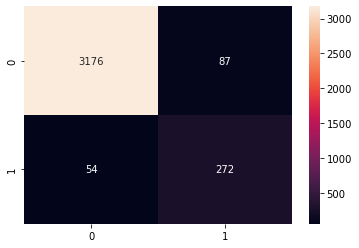

<AxesSubplot:>

In [57]:
show_confusion_matrix(model, test_dls.train)

In [ ]:
model, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

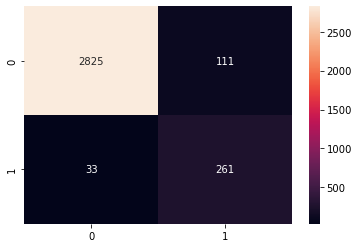

<AxesSubplot:>

In [51]:
show_confusion_matrix(model, dls.valid)

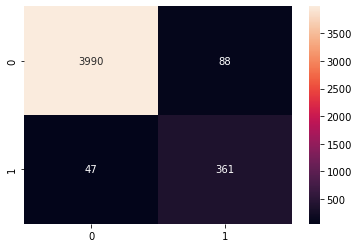

<AxesSubplot:>

In [42]:
show_confusion_matrix_cost(model, dls.valid, cost=[1, 1.25])

In [58]:
torch.save(model, f'models/{dataset}_py.pkl')

# Create output files for sigmoid and softmax output

In [50]:
def get_sigmoid_output(model, dl):
    sigmoids = pd.DataFrame()
    for inputs, y in dl:
        s = pd.DataFrame([])
        s['class'] = y.cpu().detach().numpy()
        preds = model(inputs)
        preds = torch.sigmoid(preds)
        s['sigmoid_output'] = list(preds.cpu().detach().numpy())
        sigmoids = pd.concat([sigmoids, s], ignore_index=True)
    return sigmoids

In [51]:
def get_softmax_output(model, dl):
    softmax = pd.DataFrame()
    for inputs, y in dl:
        s = pd.DataFrame([])
        s['class'] = y.cpu().detach().numpy()
        preds = model(inputs)
        preds = torch.softmax(preds, dim=1)
        s['softmax_output'] = list(preds.cpu().detach().numpy())
        softmax = pd.concat([softmax, s], ignore_index=True)
    return softmax

In [70]:
def get_prediction_output(model, dl):
    predictions = pd.DataFrame()
    for inputs, y in dl:
        p = pd.DataFrame([])
        p['class'] = y.cpu().detach().numpy()
        preds = model(inputs)
        y_preds = torch.amax(preds, dim=1)
        p['predictions'] = list(preds.cpu().detach().numpy())
        p['predicted_class'] = list(y_preds.cpu().detach().numpy())
        predictions = pd.concat([predictions, p], ignore_index=True)
    return predictions

In [53]:
def get_all_outputs(model, dl, dataset=None):
    softmax = pd.DataFrame()
    sigmoids = pd.DataFrame()
    out = pd.DataFrame()
    for inputs, y in dl:
        s = pd.DataFrame([])
        s['class'] = y.cpu().detach().numpy()
        preds = model(inputs)
        softs = torch.softmax(preds, dim=1)
        sigs = torch.sigmoid(preds)
        s['predictions'] = list(preds.cpu().detach().numpy())
        s['softmax_output'] = list(softs.cpu().detach().numpy())
        s['sigmoid_output'] = list(sigs.cpu().detach().numpy())
        if dataset != None:
            s['set'] = dataset
        out = pd.concat([out, s], ignore_index=True)
    return out

In [56]:
sigmoids_valid = get_sigmoid_output(model, dls.valid)
sigmoids_valid['set'] = 'validation'
sigmoids_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           3230 non-null   int64 
 1   sigmoid_output  3230 non-null   object
 2   set             3230 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.8+ KB


In [57]:
sigmoids_train = get_sigmoid_output(model, dls.train)
sigmoids_train['set'] = 'train'
sigmoids_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           12896 non-null  int64 
 1   sigmoid_output  12896 non-null  object
 2   set             12896 non-null  object
dtypes: int64(1), object(2)
memory usage: 302.4+ KB


In [58]:
all_sigs = pd.concat([sigmoids_train, sigmoids_valid])
all_sigs.head()

,class,sigmoid_output,set
0,0,"[0.9701672, 0.053793818]",train
1,0,"[0.76261526, 0.117157]",train
2,0,"[0.95586944, 0.019635728]",train
3,0,"[0.9676797, 0.04502932]",train
4,0,"[0.9296938, 0.10624925]",train


In [59]:
all_sigs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 0 to 3229
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           16126 non-null  int64 
 1   sigmoid_output  16126 non-null  object
 2   set             16126 non-null  object
dtypes: int64(1), object(2)
memory usage: 503.9+ KB


In [60]:
all_sigs.to_csv(path/f'{dataset}/{dataset}_cl_sigmoid_output.csv', index=False)

In [61]:
softmax_valid = get_softmax_output(model, dls.valid)
softmax_valid['set'] = 'validation'
softmax_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           3230 non-null   int64 
 1   softmax_output  3230 non-null   object
 2   set             3230 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.8+ KB


In [62]:
softmax_train = get_softmax_output(model, dls.train)
softmax_valid['set'] = 'train'
softmax_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           12896 non-null  int64 
 1   softmax_output  12896 non-null  object
dtypes: int64(1), object(1)
memory usage: 201.6+ KB


In [63]:
all_softs = pd.concat([softmax_train, softmax_valid])
all_softs.head()

,class,softmax_output,set
0,0,"[0.98613155, 0.013868446]",NaN
1,0,"[0.99508816, 0.004911895]",NaN
2,0,"[0.9640373, 0.035962734]",NaN
3,0,"[0.99701214, 0.0029878488]",NaN
4,0,"[0.99601907, 0.003980971]",NaN


In [64]:
all_softs.to_csv(path/f'{dataset}/{dataset}_cl_softmax_output.csv', index=False)

In [71]:
predictions_valid = get_prediction_output(model, dls.valid)
predictions_valid['set'] = 'validation'
predictions_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        3230 non-null   int64 
 1   predictions  3230 non-null   object
 2   set          3230 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.8+ KB


In [72]:
predictions_train = get_prediction_output(model, dls.train)
predictions_train['set'] = 'train'
predictions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        12896 non-null  int64 
 1   predictions  12896 non-null  object
 2   set          12896 non-null  object
dtypes: int64(1), object(2)
memory usage: 302.4+ KB


In [71]:
predictions_test = get_prediction_output(model, test_dls.train)
predictions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            3589 non-null   int64  
 1   predictions      3589 non-null   object 
 2   predicted_class  3589 non-null   float32
dtypes: float32(1), int64(1), object(1)
memory usage: 70.2+ KB


In [72]:
predictions_test.head()

,class,predictions,predicted_class
0,0,"[1.0686345, 0.15982893]",1.068635
1,0,"[3.294972, -3.2591784]",3.294972
2,0,"[3.8328488, -3.5713756]",3.832849
3,0,"[3.1314778, -3.682592]",3.131478
4,1,"[-0.789468, 1.3680037]",1.368004


In [55]:
predictions_test.to_csv(path/f'{dataset}/{dataset}_predictions_CNN.csv', index=False)

In [73]:
all_preds = pd.concat([predictions_train, predictions_valid])
all_preds.head()

,class,predictions,set
0,1,"[-2.544759, 1.4039788]",train
1,0,"[2.5641046, -2.8110092]",train
2,0,"[2.0580075, -2.9405768]",train
3,0,"[0.930001, -1.7360047]",train
4,1,"[-2.3095195, 1.4989927]",train


In [83]:
all_output = all_sigs
all_output['softmax_output'] = all_softs['softmax_output']
all_output['predictions'] = all_preds['predictions']
all_output = all_output.reset_index(drop=True)
all_output

,class,sigmoid_output,set,softmax_output,predictions
0,0,"[0.9701672, 0.053793818]",train,"[0.98613155, 0.013868446]","[-2.544759, 1.4039788]"
1,0,"[0.76261526, 0.117157]",train,"[0.99508816, 0.004911895]","[2.5641046, -2.8110092]"
2,0,"[0.95586944, 0.019635728]",train,"[0.9640373, 0.035962734]","[2.0580075, -2.9405768]"
3,0,"[0.9676797, 0.04502932]",train,"[0.99701214, 0.0029878488]","[0.930001, -1.7360047]"
4,0,"[0.9296938, 0.10624925]",train,"[0.99601907, 0.003980971]","[-2.3095195, 1.4989927]"
...,...,...,...,...,...
16121,0,"[0.8691852, 0.21533735]",validation,"[0.9603354, 0.039664697]","[1.8937732, -1.2930479]"
16122,0,"[0.7157499, 0.2773765]",validation,"[0.8677247, 0.13227533]","[0.92347646, -0.9575125]"
16123,0,"[0.888797, 0.06301936]",validation,"[0.9916551, 0.00834484]","[2.0785115, -2.6992207]"
16124,0,"[0.9193807, 0.05335695]",validation,"[0.9950818, 0.0049182125]","[2.4339619, -2.875918]"


In [97]:
def get_model_output(model):
    train_out = get_all_outputs(model, dls.train, 'train')
    valid_out = get_all_outputs(model, dls.valid, 'validation')
    test_out = get_all_outputs(model, test_dls.train, 'test')
    all_out = pd.concat([train_out, valid_out, test_out], ignore_index=True)
    return all_out

In [98]:
all_out = get_model_output(model)
all_out

,class,predictions,softmax_output,sigmoid_output,set
0,0,"[1.4408213, -1.9444662]","[0.9672415, 0.03275844]","[0.8085818, 0.12515801]",train
1,0,"[1.4320446, -2.369034]","[0.97814184, 0.021858195]","[0.80721974, 0.08556469]",train
2,0,"[2.3450992, -2.2143366]","[0.9896404, 0.01035952]","[0.9125439, 0.09847043]",train
3,0,"[2.9813921, -3.4311612]","[0.9983619, 0.0016381416]","[0.95172644, 0.031335667]",train
4,0,"[3.1667304, -3.548796]","[0.9987895, 0.0012104806]","[0.9595629, 0.027955273]",train
...,...,...,...,...,...
17913,0,"[1.2509729, -1.5880237]","[0.9447471, 0.0552529]","[0.7774682, 0.16966213]",test
17914,0,"[3.2267172, -3.8663087]","[0.9991698, 0.0008301893]","[0.96182746, 0.020506198]",test
17915,0,"[2.5013874, -2.653731]","[0.99426323, 0.005736697]","[0.92423904, 0.06575941]",test
17916,0,"[3.5935457, -4.649729]","[0.9997371, 0.00026295238]","[0.9732354, 0.009473588]",test


In [99]:
all_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           17918 non-null  int64 
 1   predictions     17918 non-null  object
 2   softmax_output  17918 non-null  object
 3   sigmoid_output  17918 non-null  object
 4   set             17918 non-null  object
dtypes: int64(1), object(4)
memory usage: 700.0+ KB


In [108]:
all_out.to_csv(path/f'{dataset}/{dataset}_cl_model_output.csv', index=False)

In [85]:
trues =  all_softs['class'] == all_sigs['class']
trues[:][0]

True

In [79]:
sigmoid_and_softmax.head()

,class,sigmoid_ouput,softmax_ouput
0,1,"[0.036294576, 0.950538]","[0.0019559108, 0.998044]"
1,1,"[0.036294576, 0.950538]","[0.0009883011, 0.99901164]"
2,1,"[0.036294576, 0.950538]","[0.0005348075, 0.99946517]"
3,1,"[0.036294576, 0.950538]","[0.016153919, 0.98384607]"
4,1,"[0.036294576, 0.950538]","[0.012561351, 0.9874386]"


In [81]:
sigmoids = pd.DataFrame()
sigmoids

""


In [52]:
out = torch.Tensor().to(device)
labels = torch.Tensor().to(device)
inputs, y = dls.one_batch()
len(inputs), len(y)
y

TensorCategory([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')

In [88]:
sigmoids['class'] = y.cpu()
sigmoids

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [83]:
inputs = inputs.to(device)
y = y.cpu()
labels = y
preds = model(inputs)
preds = preds.cpu().detach()
preds

tensor([[-2.8447,  3.3839],
        [ 2.5647, -2.3869],
        [ 4.1586, -4.3155],
        [ 4.9093, -4.1325],
        [-3.6357,  3.7160],
        [-4.0916,  4.4613],
        [ 1.2837, -1.4738],
        [ 2.4806, -2.0987],
        [ 2.6639, -1.6059],
        [ 3.1888, -3.3279],
        [-2.0479,  2.0318],
        [ 3.0697, -3.2240],
        [-3.2181,  2.9851],
        [-2.1545,  2.0995],
        [-3.1426,  3.2607],
        [-2.7834,  2.3165],
        [-2.1422,  2.1613],
        [ 3.6207, -3.7911],
        [ 2.2757, -2.5720],
        [ 4.5412, -4.1503],
        [-3.8547,  4.0242],
        [-3.7194,  3.5226],
        [ 4.7737, -4.5059],
        [ 3.0809, -2.9469],
        [-2.6318,  3.2373],
        [ 3.0605, -3.8618],
        [ 2.7938, -2.7927],
        [ 3.7439, -4.0104],
        [-3.5460,  3.6381],
        [ 4.6265, -4.9646],
        [-3.3536,  3.6650],
        [ 1.9615, -1.6745]])

In [84]:
preds = torch.sigmoid(preds)
preds

tensor([[0.0550, 0.9672],
        [0.9286, 0.0842],
        [0.9846, 0.0132],
        [0.9927, 0.0158],
        [0.0257, 0.9762],
        [0.0164, 0.9886],
        [0.7831, 0.1864],
        [0.9228, 0.1092],
        [0.9349, 0.1672],
        [0.9604, 0.0346],
        [0.1143, 0.8841],
        [0.9556, 0.0383],
        [0.0385, 0.9519],
        [0.1039, 0.8909],
        [0.0414, 0.9631],
        [0.0582, 0.9102],
        [0.1051, 0.8967],
        [0.9739, 0.0221],
        [0.9068, 0.0710],
        [0.9895, 0.0155],
        [0.0207, 0.9824],
        [0.0237, 0.9713],
        [0.9916, 0.0109],
        [0.9561, 0.0499],
        [0.0671, 0.9622],
        [0.9552, 0.0206],
        [0.9423, 0.0577],
        [0.9769, 0.0178],
        [0.0280, 0.9744],
        [0.9903, 0.0069],
        [0.0338, 0.9750],
        [0.8767, 0.1578]])

In [85]:
preds[:, 0]

tensor([0.0550, 0.9286, 0.9846, 0.9927, 0.0257, 0.0164, 0.7831, 0.9228, 0.9349,
        0.9604, 0.1143, 0.9556, 0.0385, 0.1039, 0.0414, 0.0582, 0.1051, 0.9739,
        0.9068, 0.9895, 0.0207, 0.0237, 0.9916, 0.9561, 0.0671, 0.9552, 0.9423,
        0.9769, 0.0280, 0.9903, 0.0338, 0.8767])

In [87]:
sigmoids['sigmoid_output'] = list(preds.cpu().detach().numpy())
sigmoids

,class,sigmoid_output
0,1,"[0.0549558, 0.9671975]"
1,0,"[0.92855555, 0.084180586]"
2,0,"[0.9846106, 0.013184357]"
3,0,"[0.9926764, 0.015788918]"
4,1,"[0.02568907, 0.97624743]"
5,1,"[0.01643768, 0.98858416]"
6,0,"[0.7830823, 0.18636067]"
7,0,"[0.9227696, 0.10922483]"
8,0,"[0.93486184, 0.16715942]"
9,0,"[0.96041244, 0.03462662]"


In [ ]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
M = torch.sum(M, dim=1)
M

In [ ]:
pred = preds.argmax(axis=1)
out = torch.cat([out, pred])
out = out.cpu()
labels = labels.cpu()
cm = confusion_matrix(labels, out)
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

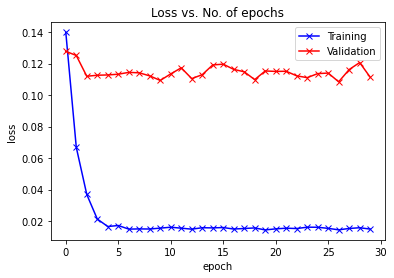

In [43]:
plot_losses(history)

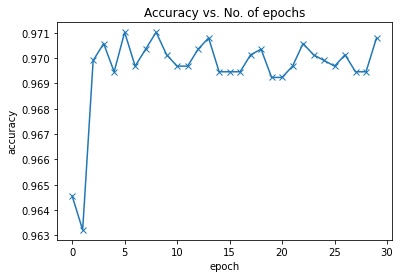

In [44]:
plot_accuracies(history)

In [ ]:
def train_and_eval(num_epochs = 5, dls = dls, lr=0.001, criterion=nn.CrossEntropyLoss()):
    history = []
    model = create_model(feature_extract=True)
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
    model, history_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)
    history.append(history_ft[0])
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model, history_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)
    for h in history_ft:
        history.append(h)
    cm = show_confusion_matrix(model, dls.valid)
    plot_losses(history)
    plot_accuracies(history)
    
    return model, history

In [ ]:
model, history = train_and_eval(num_epochs=2)

# Cost Regularized Loss function

In [ ]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [ ]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
criterion.M = M

In [ ]:
model_cs = create_model()

In [ ]:
lr = 0.0003

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(model_cs.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
plot_accuracies(history_cs)

In [ ]:
plot_losses(history_cs)

In [ ]:
show_confusion_matrix(model_cs, dls.valid)

In [ ]:
show_confusion_matrix(model_ft, dls.valid)

# Cost Sensitive loss vs CE loss

In [ ]:
feature_extract = True
lr = 0.0003

In [ ]:
model_ft = create_model(feature_extract=feature_extract)

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = True

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

In [ ]:
show_confusion_matrix(model_ft, dls.valid)

### Cost Sensitive loss model

In [ ]:
feature_extract = True
lr = 0.0003

In [ ]:
model_cs = create_model(feature_extract=feature_extract)

In [ ]:
params_to_update = model_cs.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(params_to_update, lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [ ]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
criterion.M = M

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
for param in model_cs.parameters():
    param.requires_grad = True

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(model_cs.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
show_confusion_matrix(model_cs, dls.valid)

In [ ]:
num_epochs = min(len(history_ft), len(history_cs))
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [history_cs[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]
shist = [history_ft[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="CE loss")
plt.plot(range(1,num_epochs+1),shist,label='CS loss')
plt.ylim((0.95,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()